(mmm_multidimensional_example)=
# MMM Multidimensional Example Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from pymc_marketing.mmm import GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.multidimensional import MMM
from pymc_marketing.paths import data_dir
from pymc_marketing.prior import Prior

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 8

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/Users/juanitorduz/Documents/envs/pymc-marketing-env/lib/python3.12/site-packages/pymc_marketing/mmm/multidimensional.py:55: FutureWarning: This functionality is experimental and subject to change. If you encounter any issues or have suggestions, please raise them at: https://github.com/pymc-labs/pymc-marketing/issues/new
  warnings.warn(warning_msg, FutureWarning, stacklevel=1)


In [2]:
data_path = data_dir / "mmm_example.csv"

raw_data_df = pd.read_csv(data_path, parse_dates=["date_week"])

raw_data_df = raw_data_df.rename(columns={"date_week": "date"})

raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       179 non-null    datetime64[ns]
 1   y          179 non-null    float64       
 2   x1         179 non-null    float64       
 3   x2         179 non-null    float64       
 4   event_1    179 non-null    float64       
 5   event_2    179 non-null    float64       
 6   dayofyear  179 non-null    int64         
 7   t          179 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 11.3 KB


In [3]:
a_data_df = raw_data_df.copy().assign(geo="geo_a")

b_data_df = raw_data_df.copy().assign(geo="geo_b")

rng = np.random.default_rng(42)

b_data_df["y"] = b_data_df["y"] + 1_000 * rng.normal(size=len(b_data_df))

data_df = pd.concat([a_data_df, b_data_df])

data_df = data_df.assign(
    y_max=lambda x: x.groupby("geo")["y"].transform(lambda y: y.max())
).assign(y_scaled=lambda x: x["y"] / x["y_max"])

data_df.head()

date            y        x1   x2  event_1  event_2  dayofyear  t  \
0 2018-04-02  3984.662237  0.318580  0.0      0.0      0.0         92  0   
1 2018-04-09  3762.871794  0.112388  0.0      0.0      0.0         99  1   
2 2018-04-16  4466.967388  0.292400  0.0      0.0      0.0        106  2   
3 2018-04-23  3864.219373  0.071399  0.0      0.0      0.0        113  3   
4 2018-04-30  4441.625278  0.386745  0.0      0.0      0.0        120  4   

     geo        y_max  y_scaled  
0  geo_a  8312.407544  0.479363  
1  geo_a  8312.407544  0.452681  
2  geo_a  8312.407544  0.537386  
3  geo_a  8312.407544  0.464874  
4  geo_a  8312.407544  0.534337

/Users/juanitorduz/Documents/envs/pymc-marketing-env/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


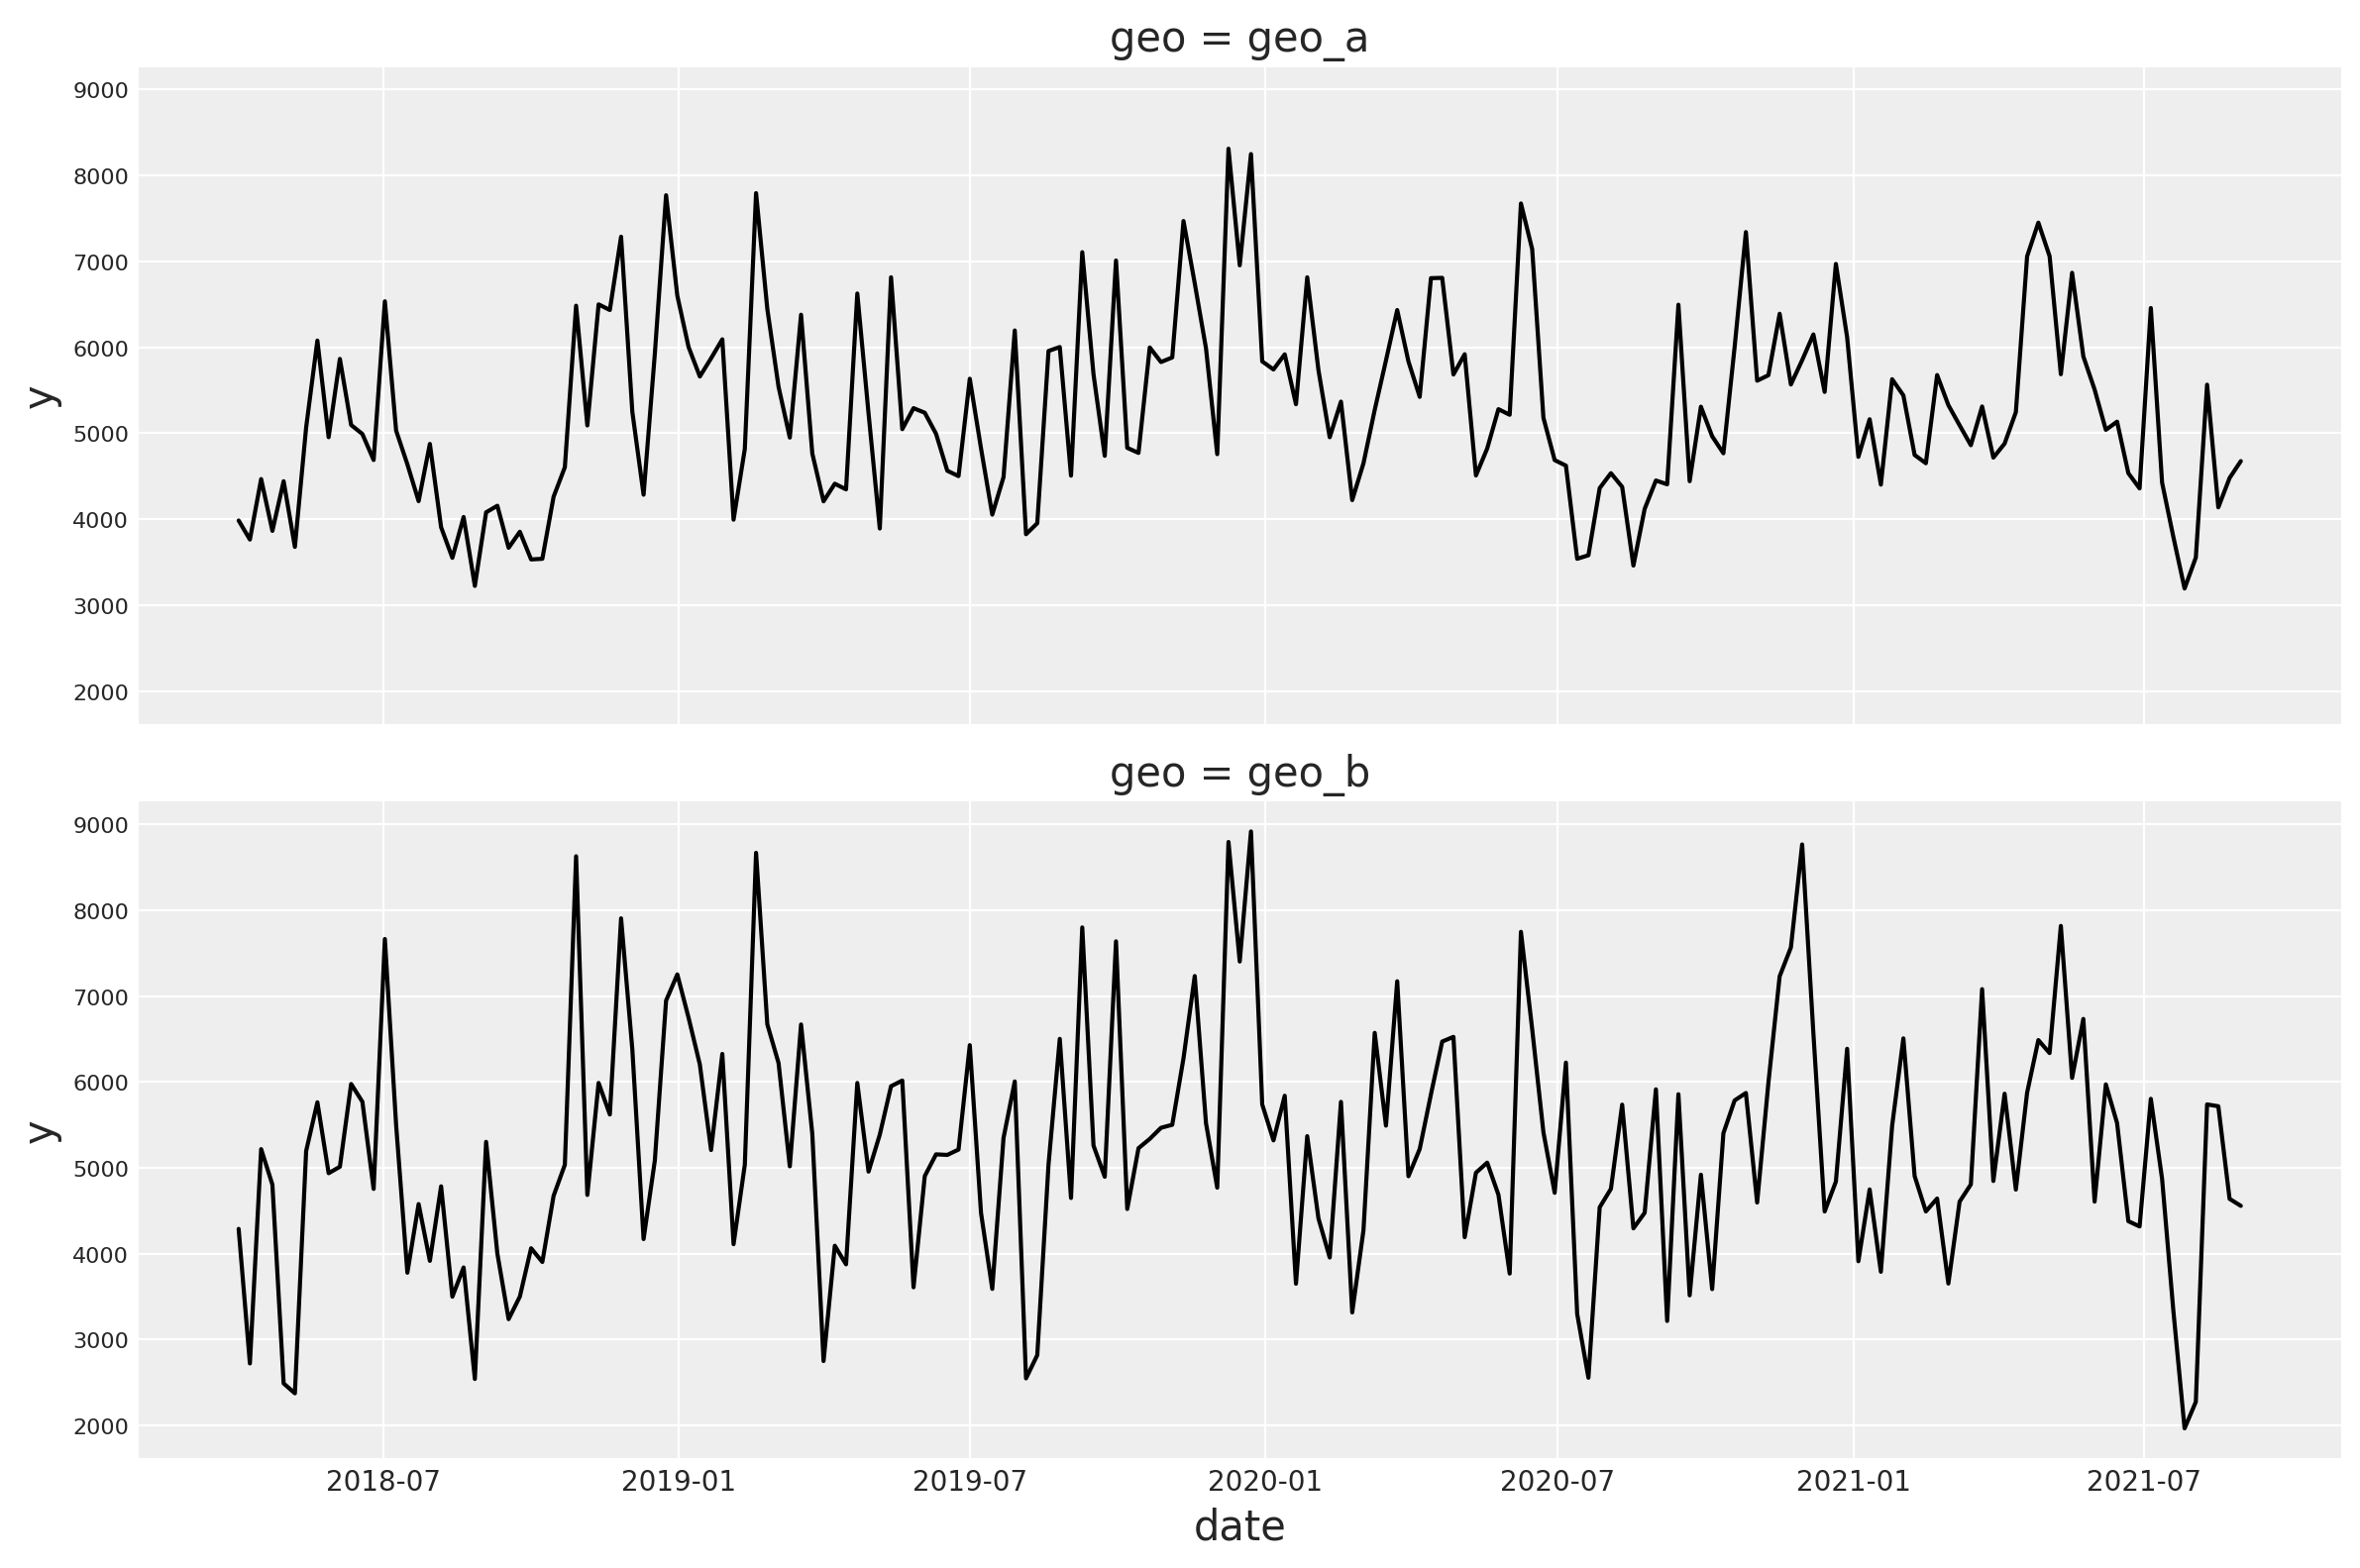

In [4]:
g = sns.relplot(
    data=data_df,
    x="date",
    y="y",
    color="black",
    col="geo",
    col_wrap=1,
    kind="line",
    height=4,
    aspect=3,
)

In [5]:
channel_columns = ["x1", "x2"]
n_channels = len(channel_columns)

sum_spend_geo_channel = data_df.groupby(["geo"]).agg({"x1": "sum", "x2": "sum"})

spend_share = (
    sum_spend_geo_channel.to_numpy() / sum_spend_geo_channel.sum(axis=1).to_numpy()
)

prior_sigma = n_channels * spend_share

In [6]:
saturation = LogisticSaturation(
    priors={
        "beta": Prior("HalfNormal", sigma=prior_sigma, dims=("channel", "geo")),
        "lam": Prior(
            "Gamma",
            mu=Prior("HalfNormal", sigma=5, dims="geo"),
            sigma=Prior("HalfNormal", sigma=2, dims="geo"),
            dims=("channel", "geo"),
        ),
    }
)

saturation.model_config

{'saturation_lam': Prior("Gamma", mu=Prior("HalfNormal", sigma=5, dims="geo"), sigma=Prior("HalfNormal", sigma=2, dims="geo"), dims=("channel", "geo")),
 'saturation_beta': Prior("HalfNormal", sigma=[[1.31263903 0.68736097]
  [1.31263903 0.68736097]], dims=("channel", "geo"))}

In [7]:
adstock = GeometricAdstock(
    priors={"alpha": Prior("Beta", alpha=2, beta=3, dims="channel")}, l_max=8
)

adstock.model_config

{'adstock_alpha': Prior("Beta", alpha=2, beta=3, dims="channel")}

In [8]:
model_config = {
    "intercept": Prior("Normal", mu=0.5, sigma=0.2, dims="geo"),
    "gamma_control": Prior("Normal", mu=0, sigma=0.05, dims="control"),
    "gamma_fourier": Prior("Laplace", mu=0, b=0.2, dims=("geo", "fourier_mode")),
    "likelihood": Prior(
        "Normal", sigma=Prior("HalfNormal", sigma=2), dims=("date", "geo")
    ),
}

In [9]:
mmm = MMM(
    date_column="date",
    target_column="y",
    channel_columns=["x1", "x2"],
    control_columns=["event_1", "event_2", "t"],
    dims=("geo",),
    adstock=adstock,
    saturation=saturation,
    yearly_seasonality=2,
    model_config=model_config,
)

In [10]:
mmm.model_config

{'intercept': Prior("Normal", mu=0.5, sigma=0.2, dims="geo"),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=2), dims=("date", "geo")),
 'gamma_control': Prior("Normal", mu=0, sigma=0.05, dims="control"),
 'gamma_fourier': Prior("Laplace", mu=0, b=0.2, dims=("geo", "fourier_mode")),
 'adstock_alpha': Prior("Beta", alpha=2, beta=3, dims="channel"),
 'saturation_lam': Prior("Gamma", mu=Prior("HalfNormal", sigma=5, dims="geo"), sigma=Prior("HalfNormal", sigma=2, dims="geo"), dims=("channel", "geo")),
 'saturation_beta': Prior("HalfNormal", sigma=[[1.31263903 0.68736097]
  [1.31263903 0.68736097]], dims=("channel", "geo"))}

In [11]:
x_train = data_df.drop(columns="y")
y_train = data_df["y"]

In [12]:
mmm.build_model(
    X=x_train,
    y=y_train,
)

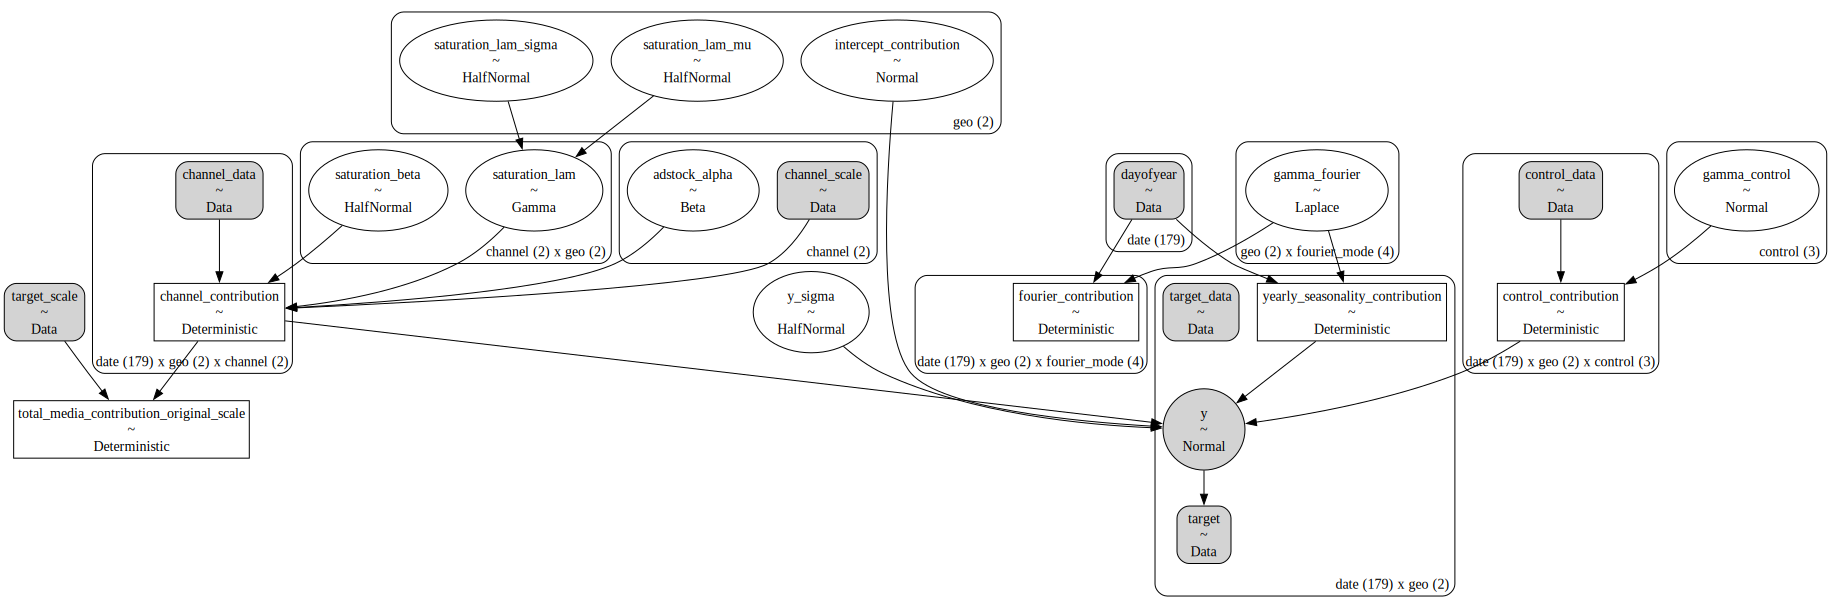

In [13]:
pm.model_to_graphviz(mmm.model)

In [14]:
mmm.add_original_scale_contribution_variable(
    var=[
        "channel_contribution",
        "control_contribution",
        "intercept_contribution",
        "yearly_seasonality_contribution",
    ]
)

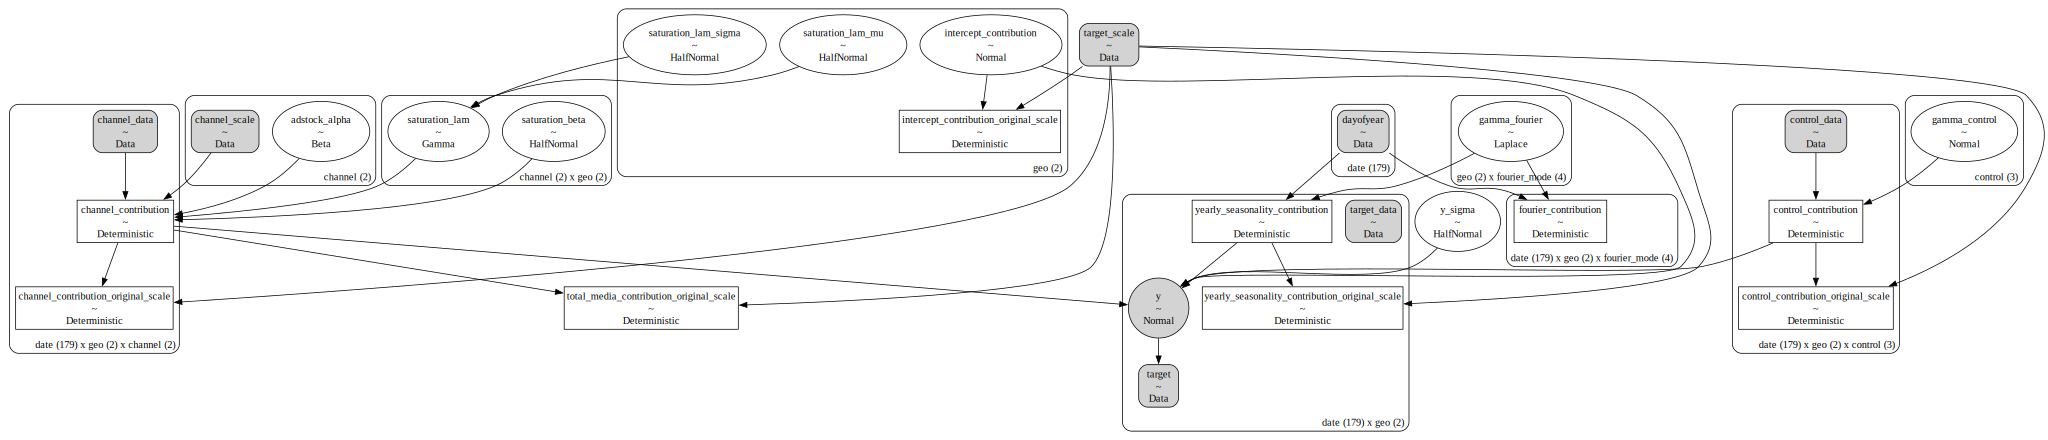

In [15]:
pm.model_to_graphviz(mmm.model)

In [16]:
prior_predictive = mmm.sample_prior_predictive(X=x_train, samples=1_000)

Sampling: [adstock_alpha, gamma_control, gamma_fourier, intercept_contribution, saturation_beta, saturation_lam, saturation_lam_mu, saturation_lam_sigma, y, y_sigma]


/Users/juanitorduz/Documents/envs/pymc-marketing-env/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


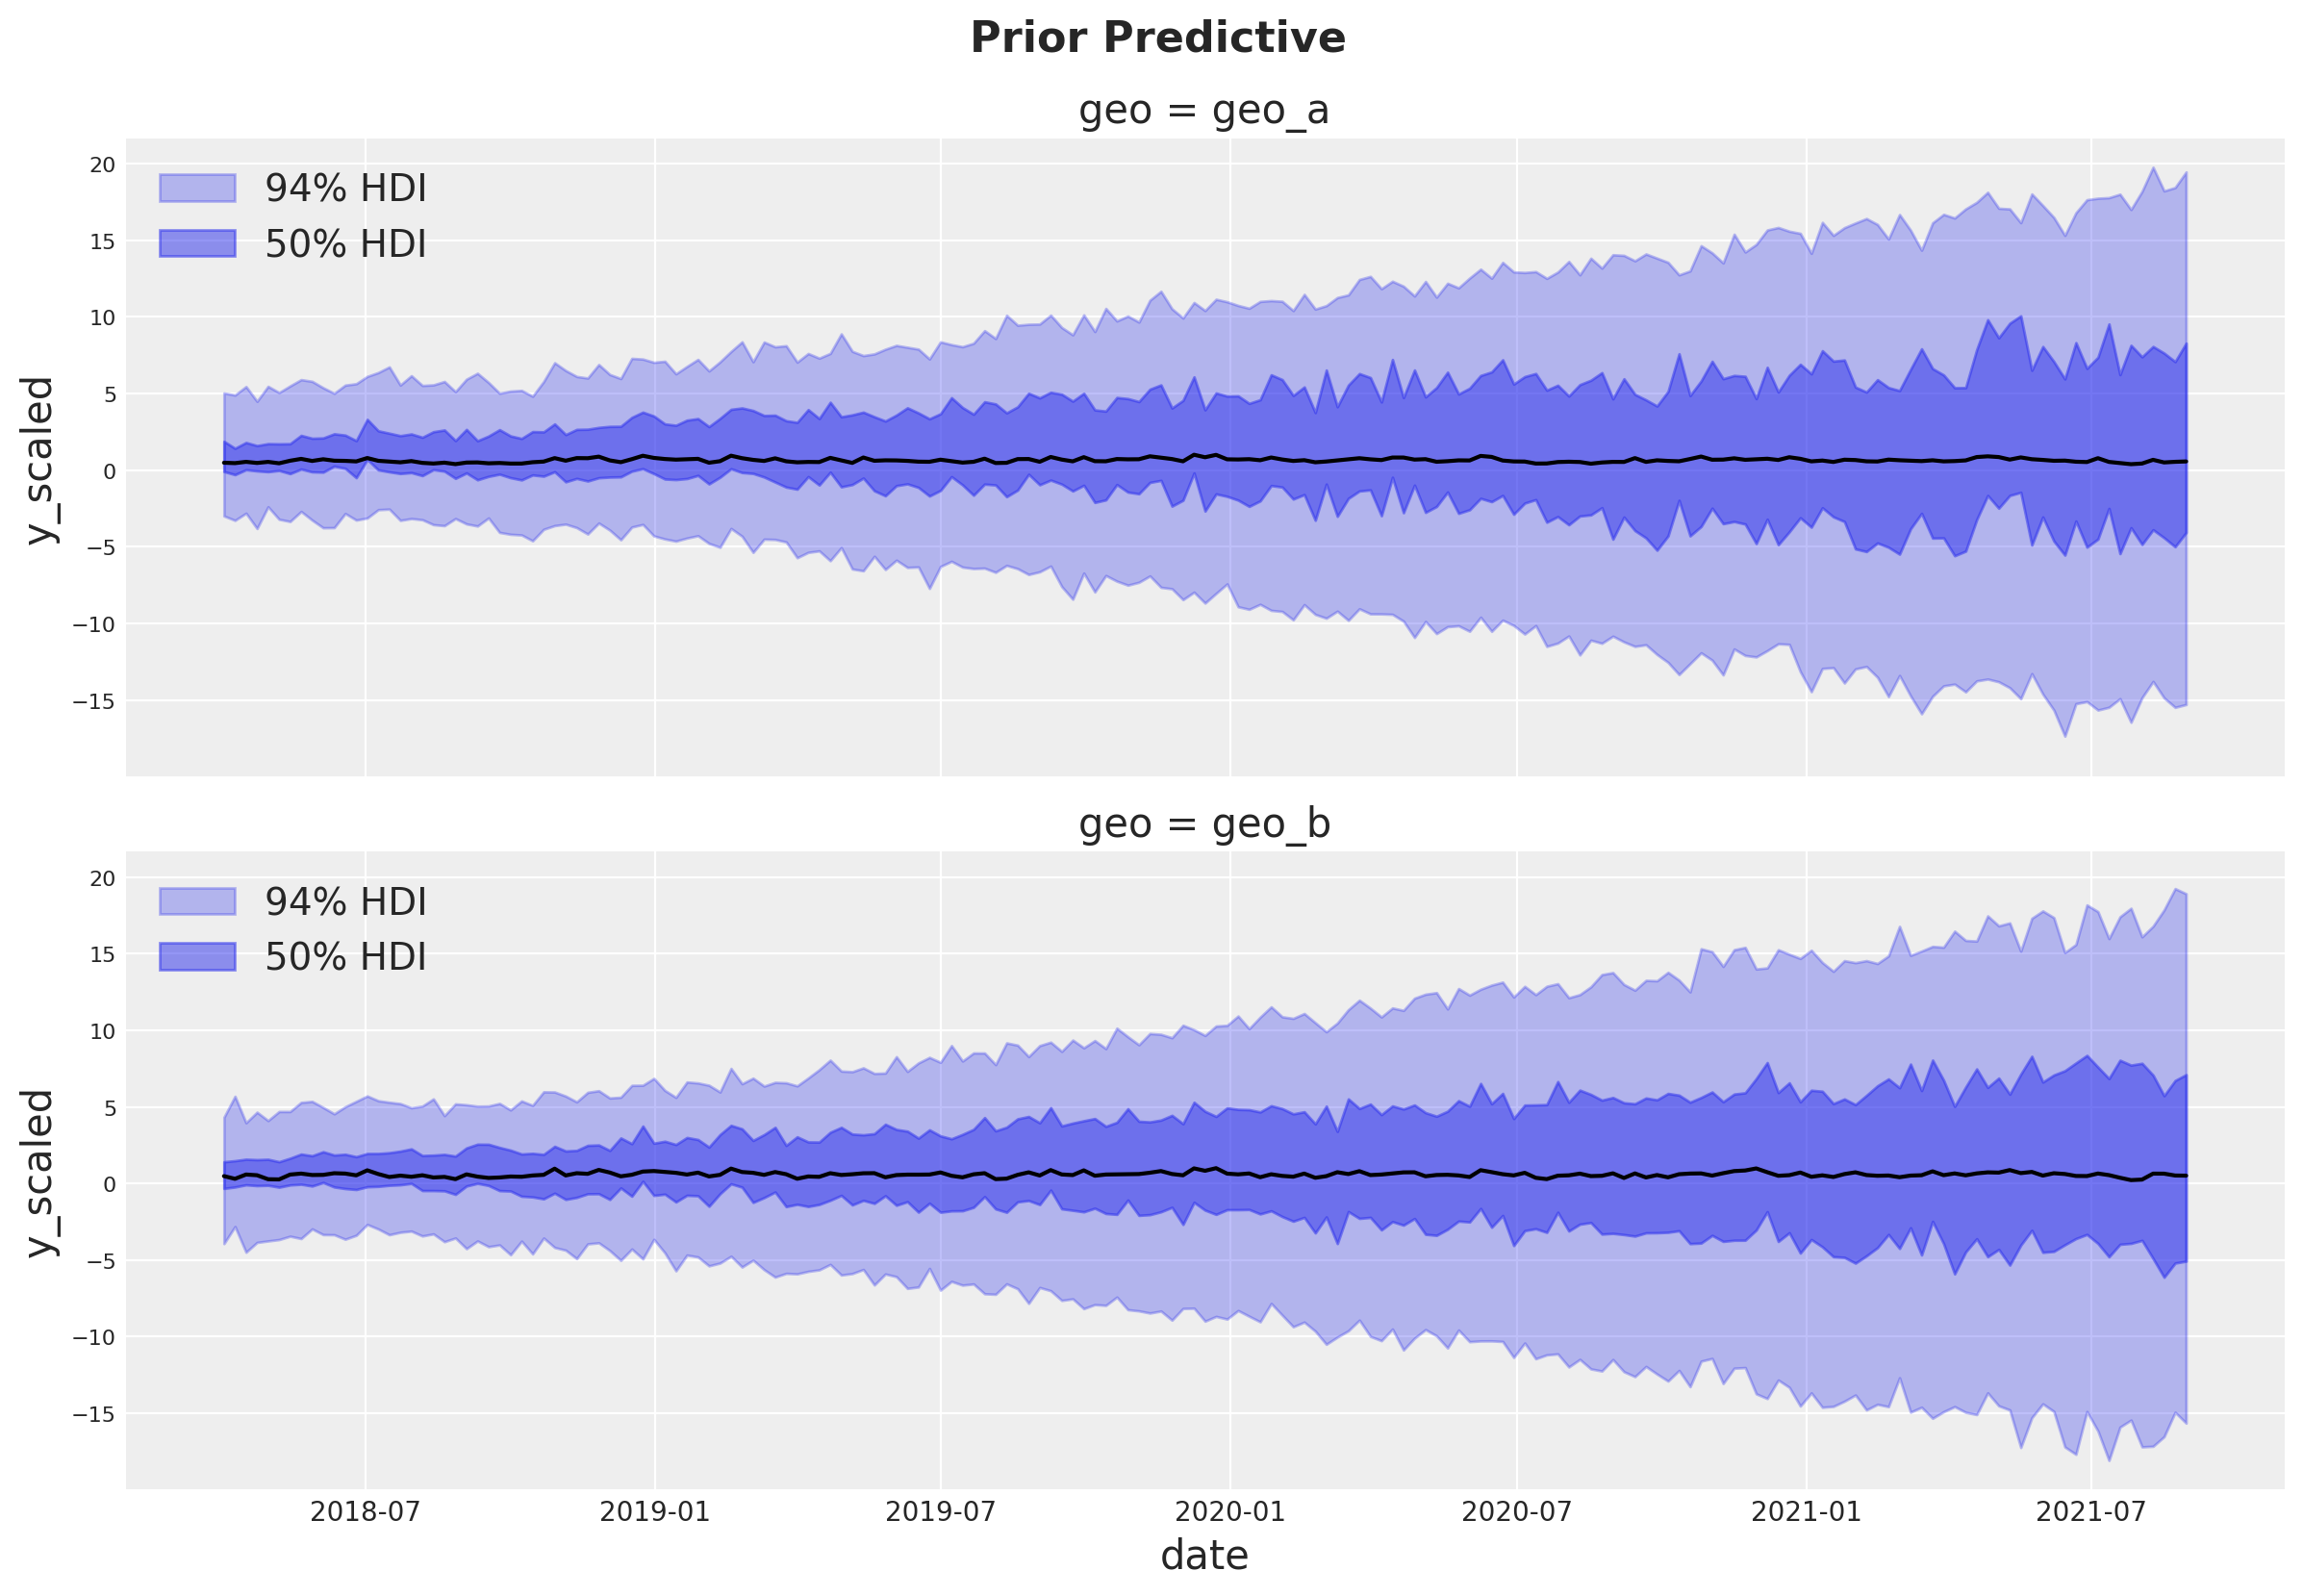

In [17]:
g = sns.relplot(
    data=data_df,
    x="date",
    y="y_scaled",
    color="black",
    col="geo",
    col_wrap=1,
    kind="line",
    height=4,
    aspect=3,
)

axes = g.axes.flatten()

for ax, geo in zip(axes, mmm.model.coords["geo"], strict=True):
    az.plot_hdi(
        x=mmm.model.coords["date"],
        y=prior_predictive.sel(geo=geo)["y"].unstack().transpose(..., "date"),
        smooth=False,
        color="C0",
        hdi_prob=0.94,
        fill_kwargs={"alpha": 0.3, "label": "94% HDI"},
        ax=ax,
    )
    az.plot_hdi(
        x=mmm.model.coords["date"],
        y=prior_predictive.sel(geo=geo)["y"].unstack().transpose(..., "date"),
        smooth=False,
        color="C0",
        hdi_prob=0.5,
        fill_kwargs={"alpha": 0.5, "label": "50% HDI"},
        ax=ax,
    )
    ax.legend()

g.figure.suptitle("Prior Predictive", fontsize=16, fontweight="bold", y=1.03);

In [18]:
mmm.fit(
    X=data_df.drop(columns="y"),
    y=data_df["y"],
    chains=4,
    target_accept=0.9,
    nuts_sampler="numpyro",
    random_seed=42,
)

mmm.sample_posterior_predictive(
    X=data_df.drop(columns="y"),
    extend_idata=True,
    combined=True,
    random_seed=42,
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2025-03-06 14:33:02.419948: E external/xla/xla/service/slow_operation_alarm.cc:73] Constant folding an instruction is taking > 1s:

  %reduce.4 = f64[4,1000,179,2,2]{4,3,2,1,0} reduce(f64[4,1000,1,179,2,2]{5,4,3,2,1,0} %broadcast.18, f64[] %constant.32), dimensions={2}, to_apply=%region_5.135, metadata={op_name="jit(process_fn)/jit(main)/reduce_prod" source_file="/var/folders/p5/ndc9d2b90_x9vnt8nzzygcb00000gp/T/tmpejueu4na" source_line=97}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-03-06 14:33:05.729249: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 4.314323s
Constant folding an instruction is taking 

Output()

<xarray.Dataset> Size: 12MB
Dimensions:  (date: 179, geo: 2, sample: 4000)
Coordinates:
  * date     (date) datetime64[ns] 1kB 2018-04-02 2018-04-09 ... 2021-08-30
  * geo      (geo) <U5 40B 'geo_a' 'geo_b'
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, geo, sample) float64 11MB 0.377 0.4994 ... 0.257 0.1874
Attributes:
    created_at:                 2025-03-06T13:33:23.924779+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.1

In [19]:
mmm.idata.sample_stats.diverging.sum().item()

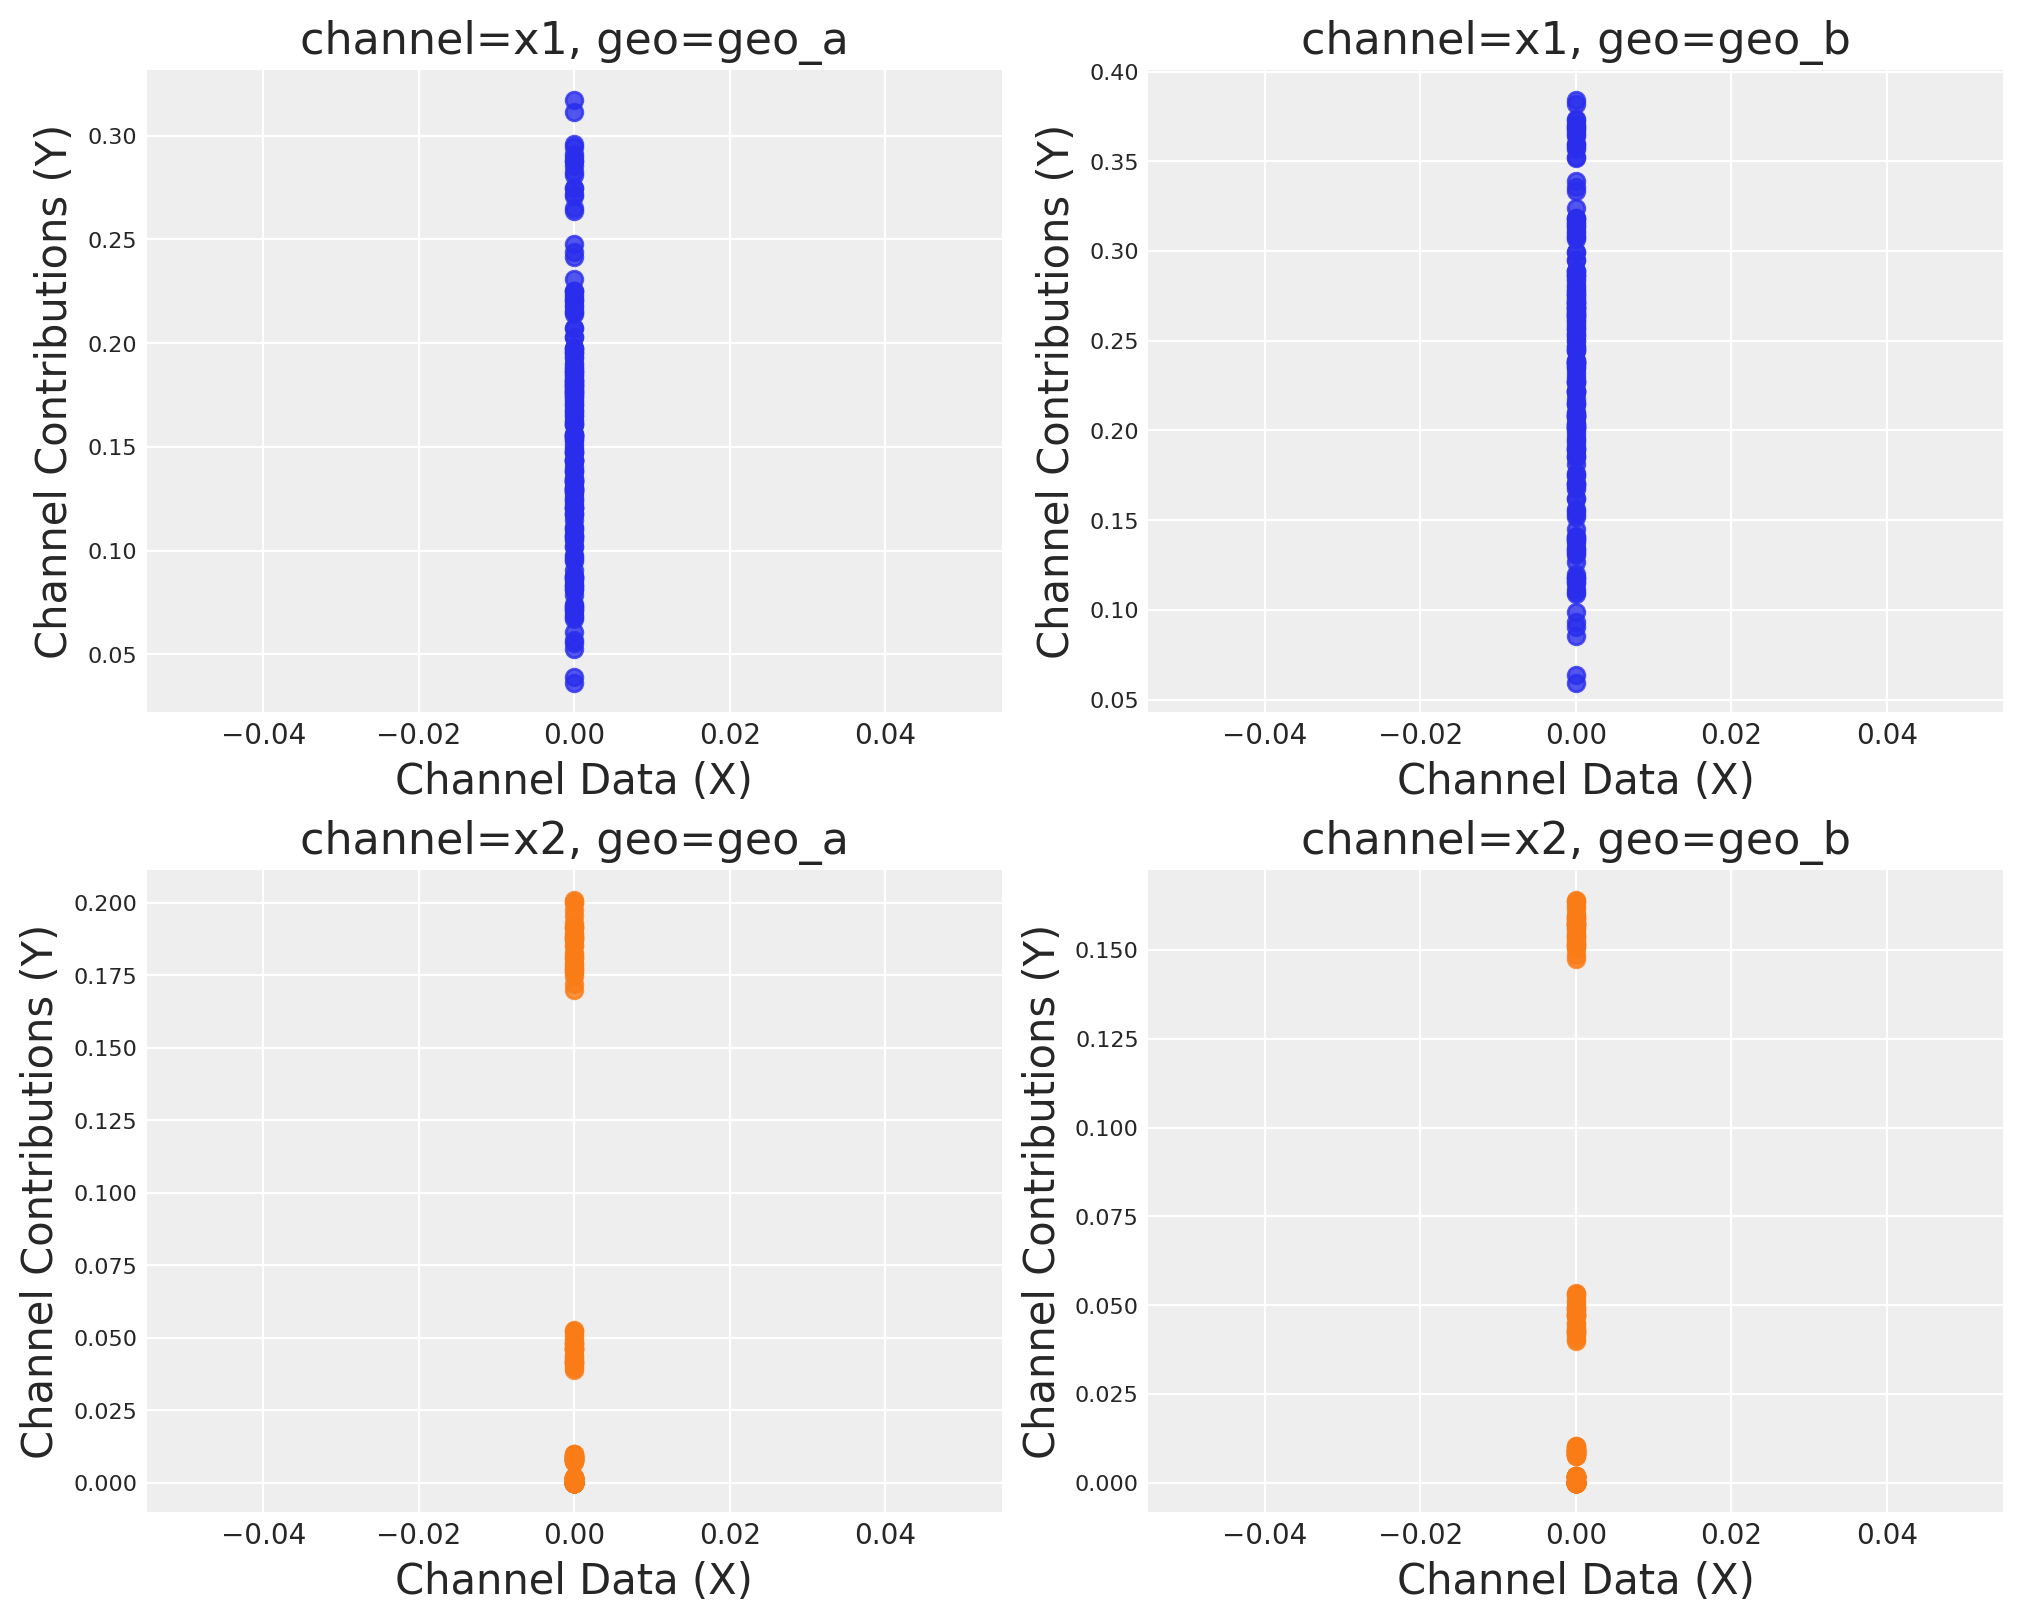

In [20]:
mmm.plot.saturation_curves_scatter();

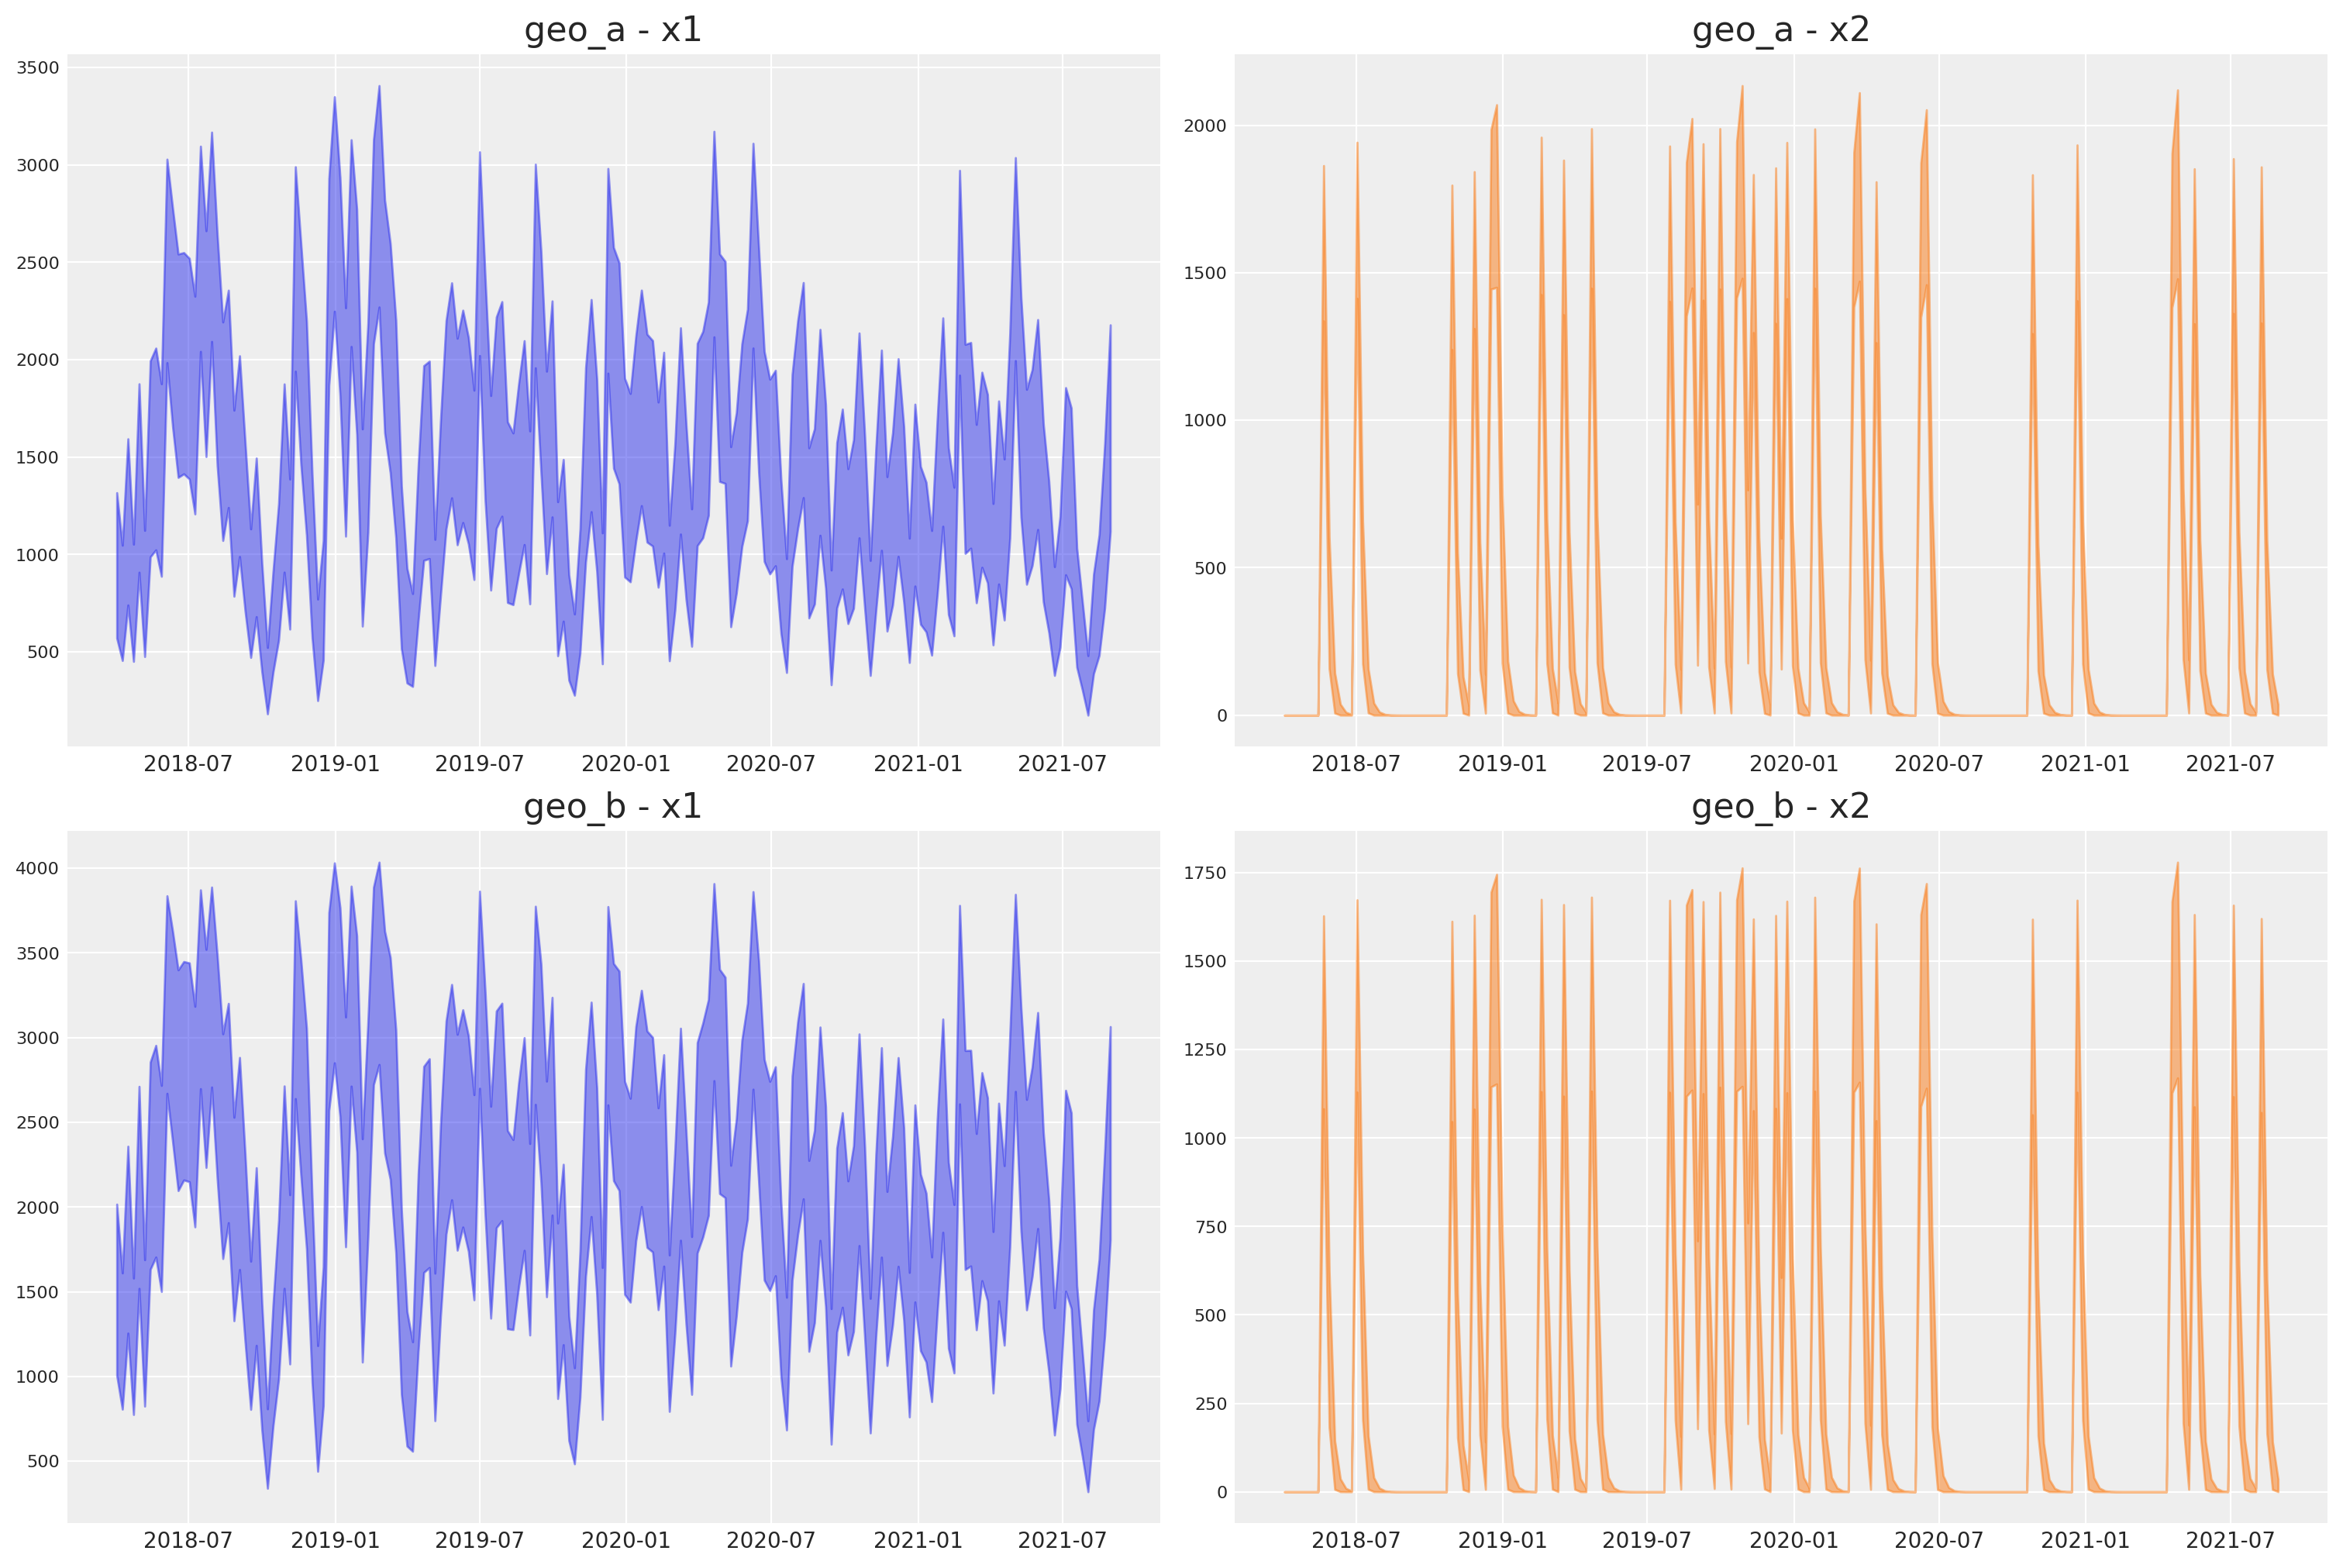

In [21]:
fig, axes = plt.subplots(
    nrows=len(mmm.model.coords["geo"]),
    ncols=len(mmm.model.coords["channel"]),
    figsize=(15, 10),
    layout="constrained",
)

for i, geo in enumerate(mmm.model.coords["geo"]):
    for j, channel in enumerate(mmm.model.coords["channel"]):
        ax = axes[i, j]
        az.plot_hdi(
            x=mmm.model.coords["date"],
            y=mmm.idata["posterior"]["channel_contribution_original_scale"].sel(
                geo=geo, channel=channel
            ),
            color=f"C{j}",
            smooth=False,
            hdi_prob=0.94,
            ax=ax,
        )
        ax.set_title(f"{geo} - {channel}")

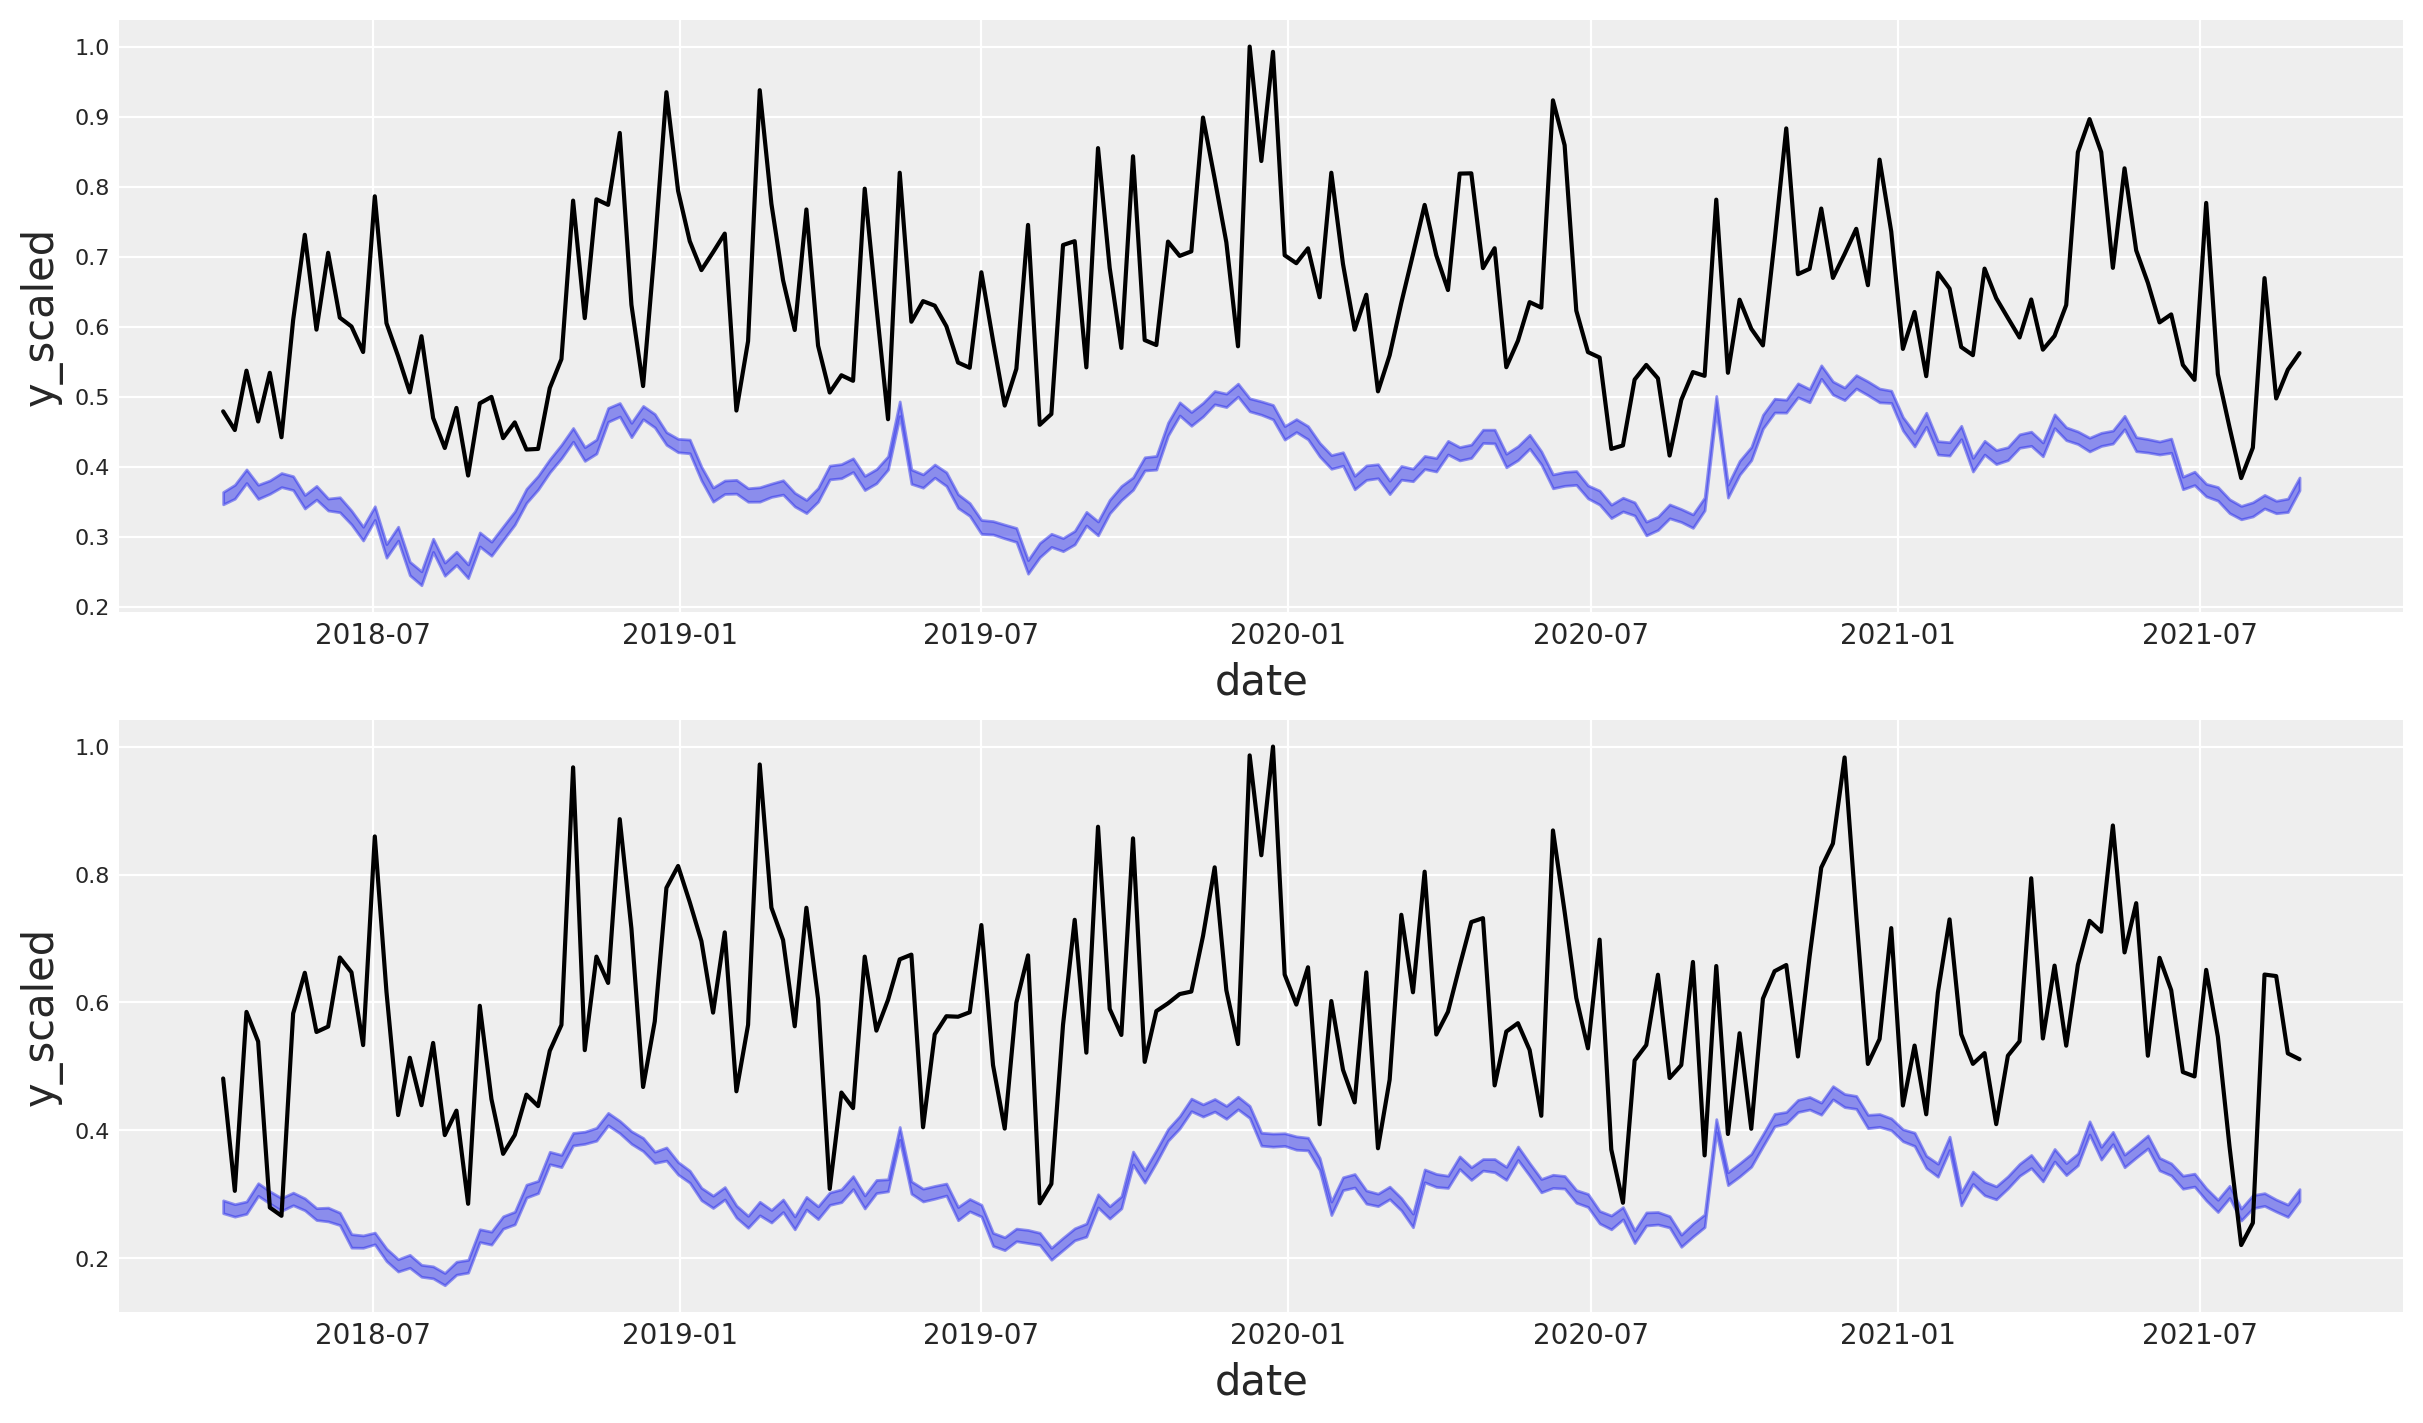

In [22]:
fig, axes = plt.subplots(
    nrows=len(mmm.model.coords["geo"]),
)

for i, geo in enumerate(mmm.model.coords["geo"]):
    ax = axes[i]
    az.plot_hdi(
        x=mmm.model.coords["date"],
        y=mmm.idata["posterior_predictive"].sel(geo=geo)["y"],
        color="C0",
        smooth=False,
        hdi_prob=0.1,
        ax=ax,
    )

    sns.lineplot(
        data=data_df.query("geo == @geo"),
        x="date",
        y="y_scaled",
        color="black",
        ax=ax,
    )

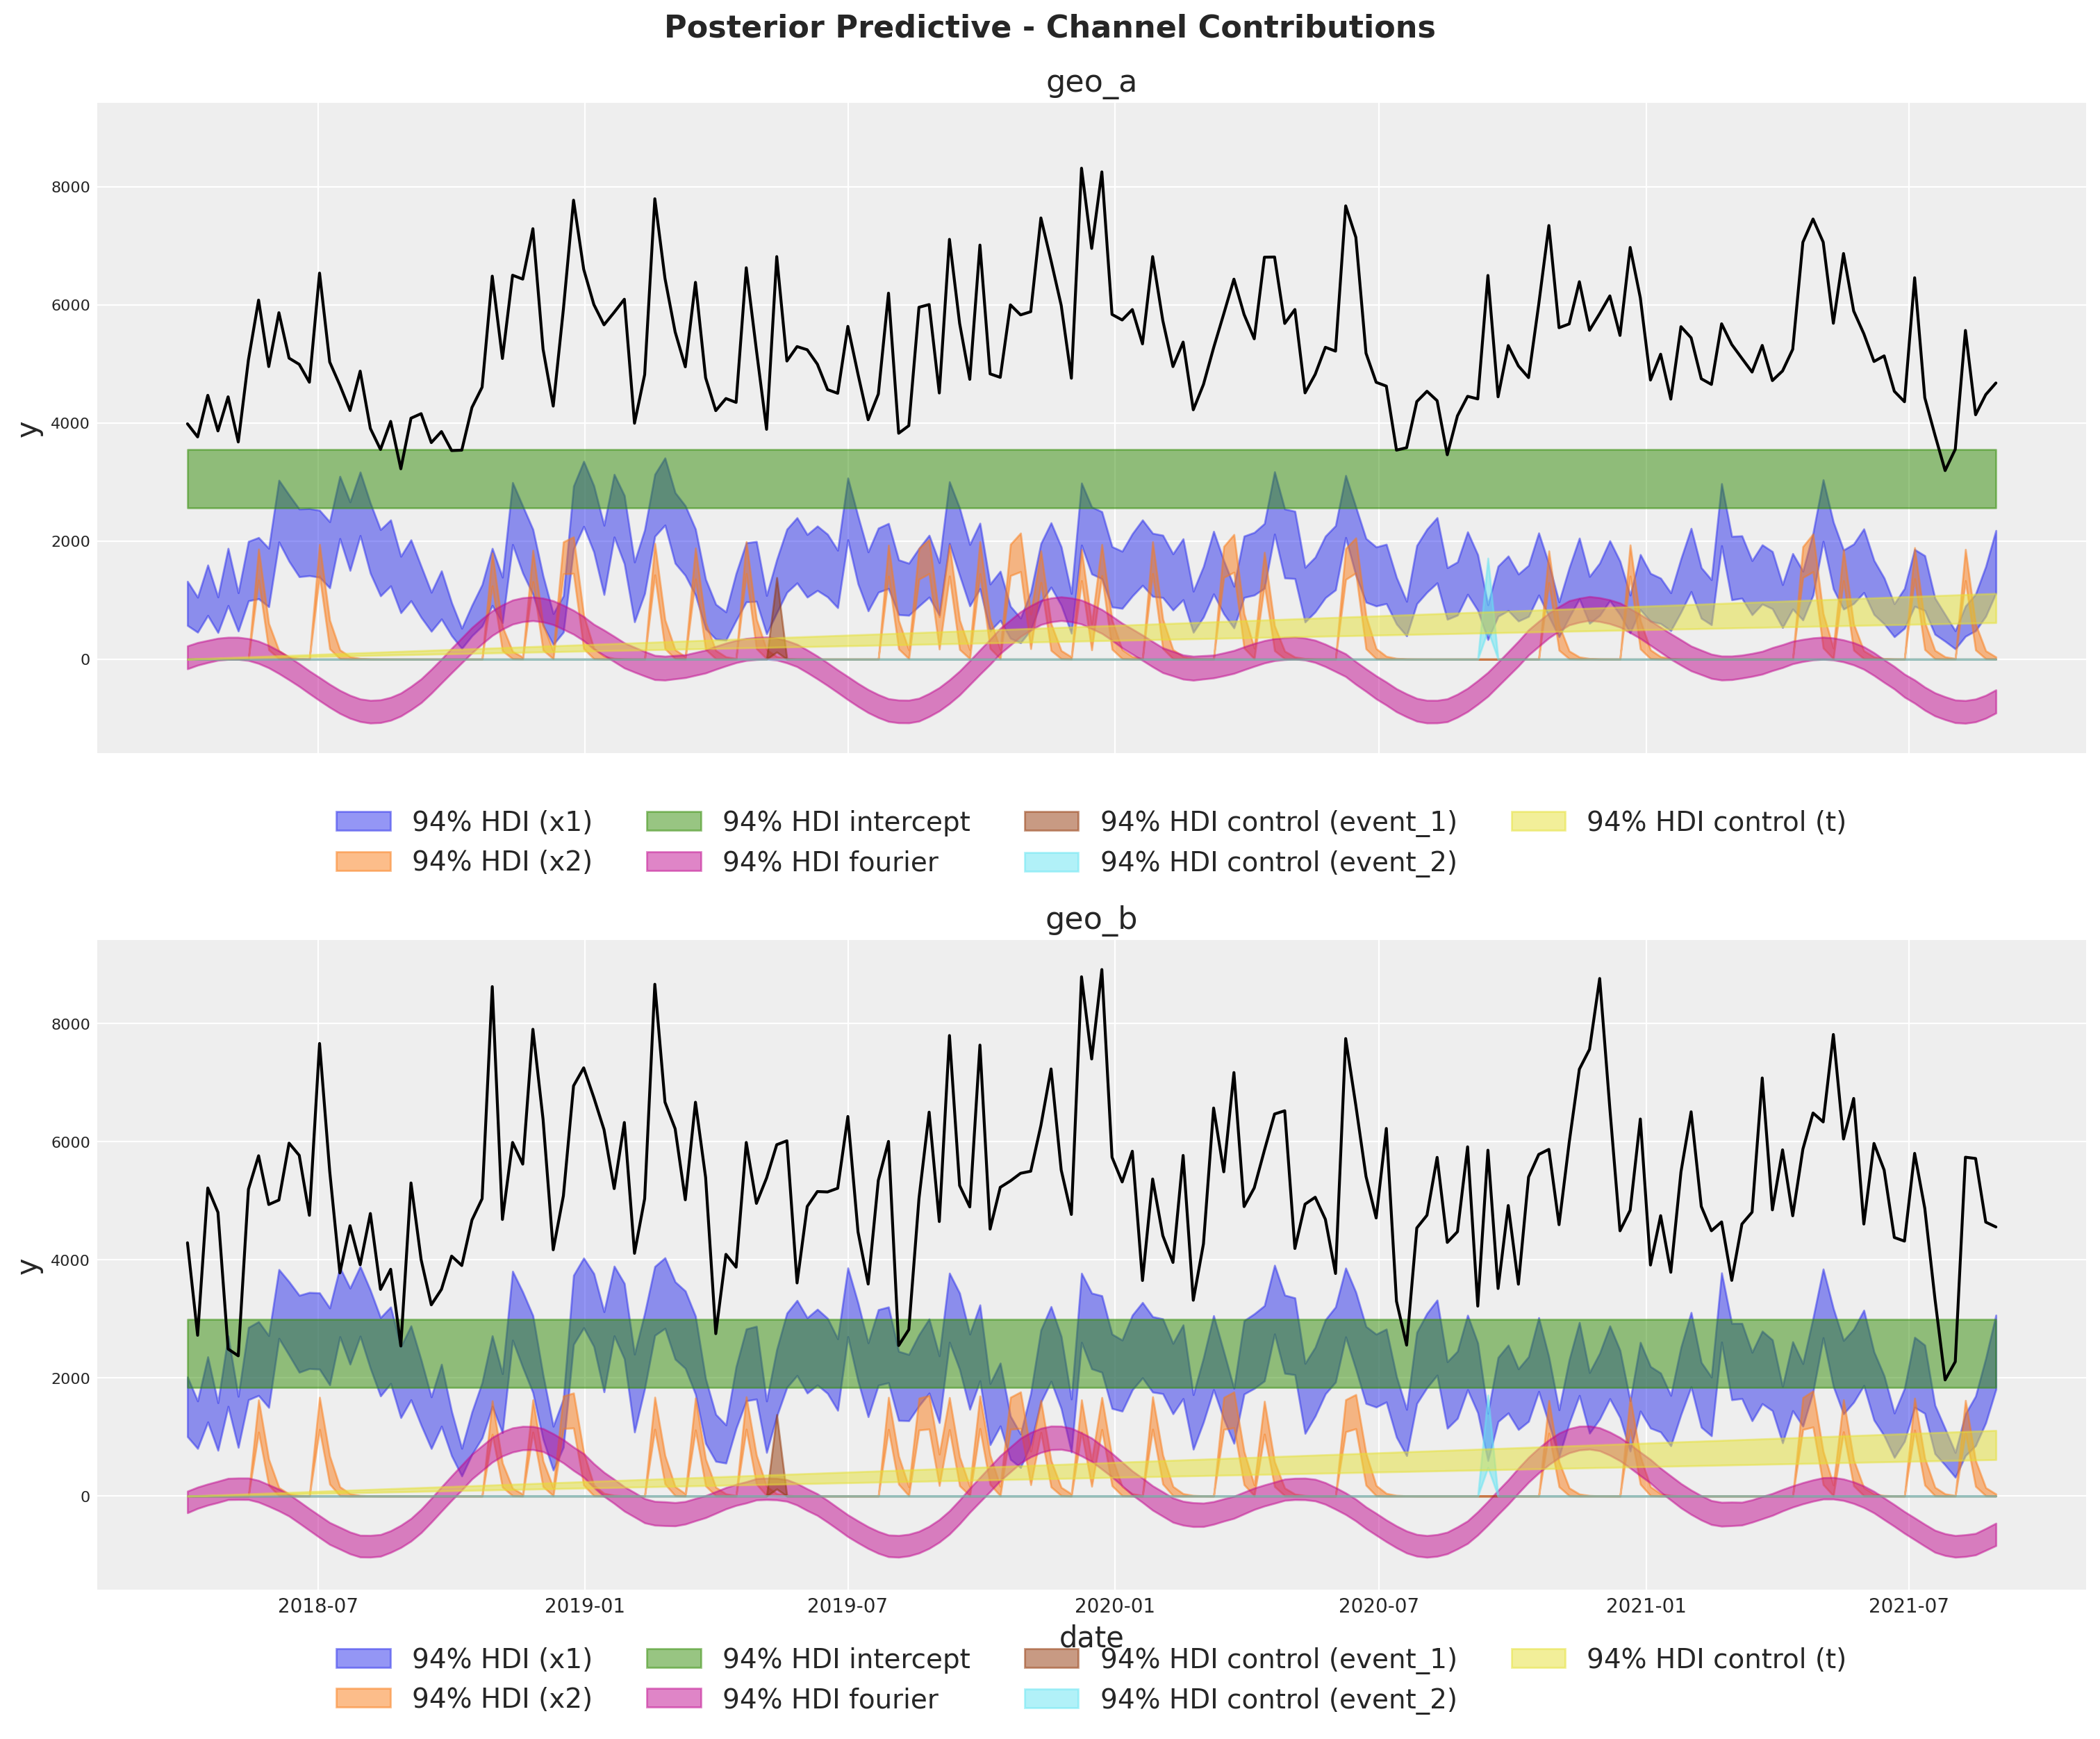

In [23]:
fig, axes = plt.subplots(
    nrows=len(mmm.model.coords["geo"]),
    figsize=(15, 12),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i, geo in enumerate(mmm.model.coords["geo"]):
    ax = axes[i]

    for j, channel in enumerate(mmm.model.coords["channel"]):
        az.plot_hdi(
            x=mmm.model.coords["date"],
            y=mmm.idata["posterior"]["channel_contribution_original_scale"].sel(
                geo=geo, channel=channel
            ),
            color=f"C{j}",
            smooth=False,
            hdi_prob=0.94,
            fill_kwargs={"alpha": 0.5, "label": f"94% HDI ({channel})"},
            ax=ax,
        )

    az.plot_hdi(
        x=mmm.model.coords["date"],
        y=mmm.idata["posterior"]["intercept_contribution_original_scale"]
        .sel(geo=geo)
        .expand_dims({"date": mmm.model.coords["date"]})
        .transpose(..., "date"),
        color="C2",
        smooth=False,
        hdi_prob=0.94,
        fill_kwargs={"alpha": 0.5, "label": "94% HDI intercept"},
        ax=ax,
    )

    az.plot_hdi(
        x=mmm.model.coords["date"],
        y=mmm.idata["posterior"]["yearly_seasonality_contribution_original_scale"].sel(
            geo=geo,
        ),
        color="C3",
        smooth=False,
        hdi_prob=0.94,
        fill_kwargs={"alpha": 0.5, "label": "94% HDI fourier"},
        ax=ax,
    )

    for k, control in enumerate(mmm.model.coords["control"]):
        az.plot_hdi(
            x=mmm.model.coords["date"],
            y=mmm.idata["posterior"]["control_contribution_original_scale"].sel(
                geo=geo, control=control
            ),
            color=f"C{4 + k}",
            smooth=False,
            hdi_prob=0.94,
            fill_kwargs={"alpha": 0.5, "label": f"94% HDI control ({control})"},
            ax=ax,
        )

    sns.lineplot(
        data=data_df.query("geo == @geo"),
        x="date",
        y="y",
        color="black",
        ax=ax,
    )
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.05),
        ncol=4,
    )
    ax.set(title=f"{geo}")

fig.suptitle(
    "Posterior Predictive - Channel Contributions",
    fontsize=16,
    fontweight="bold",
    y=1.03,
);